In [1]:
library(hce, warn.conflicts = FALSE)
library(tidyverse)
library(gt)
library(survival)
library(survminer, warn.conflicts = FALSE)
# see what is being loaded by hce package
objects('package:hce')

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpubr



[1] "ADET"        "ADLB"        "ADSL"        "COVID19"     "COVID19b"   
 [6] "COVID19plus" "HCE1"        "HCE2"        "HCE3"        "HCE4"       
[11] "IWP"         "KHCE"        "as_hce"      "calcWINS"    "calcWO"     
[16] "hce"         "minWO"       "powerWO"     "propWINS"    "regWO"      
[21] "simADHCE"    "simHCE"      "simORD"      "sizeWO"      "sizeWR"     
[26] "stratWO"     "summaryWO"

## Create `Table 1 - Baseline Characteristics`

Since we only need data from the baseline (ADSL) dataframe for this table, no need to do any merging yet

In [2]:
head(ADSL)
head(ADLB)

,ID,TRTPN,EGFRBL,STRATAN
,<int>,<int>,<int>,<int>
1,1,1,44,1
2,2,1,31,3
3,3,1,28,4
4,4,1,61,4
5,5,1,37,4
6,6,2,35,1


,ID,TRTPN,AVAL,ADAY,AVISITN,PARAM,PARAMCD,PARAMN
,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<int>
1,1,1,40,357,7,eGFR measurements,eGFR,7
2,1,1,49,119,5,eGFR measurements,eGFR,7
3,1,1,41,238,6,eGFR measurements,eGFR,7
4,1,1,36,469,8,eGFR measurements,eGFR,7
5,1,1,40,721,10,eGFR measurements,eGFR,7
6,1,1,34,602,9,eGFR measurements,eGFR,7


In [3]:
# Recode treatment groups so we don't mix up active/control later on
ADSL <- ADSL %>% 
    mutate(
        TRT_GRP = case_when(
            TRTPN == 1 ~ "Active",
            TRTPN == 2 ~ "Control", 
            TRUE ~ "Unknown" # Other values if exists
        )
    )
table(ADSL$TRT_GRP)

# Categorize baseline eGFR levels
ADSL <- ADSL %>%
    mutate(eGFR_cat = case_when(
        EGFRBL >= 60 ~ '>=60 ml/min/1.73 m2',
        EGFRBL >= 45 & EGFRBL < 60 ~ '45 to <60 ml/min/1.73 m2',
        EGFRBL >= 30 & EGFRBL < 45 ~ '30 to <45 ml/min/1.73 m2',
        EGFRBL < 30 ~ '<30 ml/min/1.73 m2',
        EGFRBL > median(EGFRBL, na.rm = TRUE) ~ '>median - no. (%)',
        )
    )


 Active Control 
    750     750 

In [4]:
# Use dplyr style piping to calculate grouped (Active, Control) summary statistics 
# These values will later be combined and reformatted to the specifications requestsed in the table
summary_table = ADSL %>% 
    group_by(TRT_GRP) %>%
    summarize(
        n = n(),
        # Baseline eGFR
        eGFR_bl_mean = mean(EGFRBL, na.rm=TRUE),
        eGFR_bl_sd = sd(EGFRBL, na.rm=TRUE),
        eGFR_bl_median = median(EGFRBL, na.rm=TRUE),
        eGFR_bl_iqr = IQR(EGFRBL, na.rm=TRUE),
        eGFR_bl_25ci = quantile(EGFRBL, 0.25, na.rm=TRUE),
        eGFR_bl_75ci = quantile(EGFRBL, 0.75, na.rm=TRUE),
        eGFR_bl_min = min(EGFRBL, na.rm=TRUE),
        eGFR_bl_max = max(EGFRBL, na.rm=TRUE),
        eGFR_bl_missing = sum(is.na(EGFRBL)),

        # eGFR percentiles (Number/percentile of patients in each category)
        eGFR_gte60_sum = sum(eGFR_cat == '>=60 ml/min/1.73 m2'),
        eGFR_gte60_perc = mean(eGFR_cat == '>=60 ml/min/1.73 m2') * 100,
        eGFR_45to60_sum = sum(eGFR_cat == '45 to <60 ml/min/1.73 m2'),
        eGFR_45to60_perc = mean(eGFR_cat == '45 to <60 ml/min/1.73 m2') * 100,
        eGFR_30to45_sum = sum(eGFR_cat == '30 to <45 ml/min/1.73 m2'),
        eGFR_30to45_perc = mean(eGFR_cat == '30 to <45 ml/min/1.73 m2') * 100,
        eGFR_lt30_sum = sum(eGFR_cat == '<30 ml/min/1.73 m2'),
        eGFR_lt30_perc = mean(eGFR_cat == '<30 ml/min/1.73 m2') * 100,
        eGFR_gt_median_perc = mean(EGFRBL > median(ADSL$EGFRBL, na.rm = TRUE)) *100,
        eGFR_gt_median_sum = sum(EGFRBL > median(ADSL$EGFRBL, na.rm = TRUE)),

        # CKD Risk (Number/percentile of patients in each category)
        strata1_sum = sum(STRATAN == 1, na.rm=TRUE),
        strata1_perc = mean(STRATAN == 1, na.rm=TRUE) * 100,
        strata2_sum = sum(STRATAN == 2, na.rm=TRUE),
        strata2_perc = mean(STRATAN == 2, na.rm=TRUE) * 100,
        strata3_sum = sum(STRATAN == 3, na.rm=TRUE),
        strata3_perc = mean(STRATAN == 3, na.rm=TRUE) * 100,
        strata4_sum = sum(STRATAN == 4, na.rm=TRUE),
        strata4_perc = mean(STRATAN == 4, na.rm=TRUE) * 100,
    )
# transpose the table for easier data mutations below
summary_table_t = summary_table %>% t() %>% as.data.frame()

head(summary_table_t)

,V1,V2
,<chr>,<chr>
TRT_GRP,Active,Control
n,750,750
eGFR_bl_mean,43.62133,42.76133
eGFR_bl_sd,12.71063,12.24027
eGFR_bl_median,42,41
eGFR_bl_iqr,20,18


In [5]:
# the above code produces a long dataframe with grouped summary stats, 
# but we wan't to combine many of the values into composite cells for a more readable table 1

# Use mutate to round and string concatenate the values requested for table1
pivot_and_combine <- summary_table %>%
  mutate(
    `Mean +- SD - ml/min/1.73 m2` = paste0(round(eGFR_bl_mean, 1), "+-", round(eGFR_bl_sd, 1)),
    `Median (interquartile range)` = paste0(round(eGFR_bl_median, 1), " (", round(eGFR_bl_25ci, 1), "-", round(eGFR_bl_75ci, 1), ")"),
    `>=60 ml/min/1.73 m2` = paste0(round(eGFR_gte60_sum, 1), " (", round(eGFR_gte60_perc, 1), "%)"),
    `45 to <60 ml/min/1.73 m2` = paste0(round(eGFR_45to60_sum, 1), " (", round(eGFR_45to60_perc, 1), "%)"),
    `30 to <45 ml/min/1.73 m2` = paste0(round(eGFR_30to45_sum, 1), " (", round(eGFR_30to45_perc, 1), "%)"),
    `<30 ml/min/1.73 m2` = paste0(round(eGFR_lt30_sum, 1), " (", round(eGFR_lt30_perc, 1), "%)"),
    `>median - no. (%)` = paste0(round(eGFR_gt_median_sum, 1), " (", round(eGFR_gt_median_perc, 1), "%)"),
    `Strata 1 - no. (%)` = paste0(round(strata1_sum, 1), " (", round(strata1_perc, 1), "%)"),
    `Strata 2 - no. (%)` = paste0(round(strata2_sum, 1), " (", round(strata2_perc, 1), "%)"),
    `Strata 3 - no. (%)` = paste0(round(strata3_sum, 1), " (", round(strata3_perc, 1), "%)"),
    `Strata 4 - no. (%)` = paste0(round(strata4_sum, 1), " (", round(strata4_perc, 1), "%)"),
  ) 
# show the added columns
print(pivot_and_combine)

# only keep the rows that will ultimately be displayed in the cleaned Table 1
table1_fmt <- pivot_and_combine %>% select(
  `Mean +- SD - ml/min/1.73 m2`,
  `Median (interquartile range)`,
  `>=60 ml/min/1.73 m2`,
  `45 to <60 ml/min/1.73 m2`,
  `30 to <45 ml/min/1.73 m2`,
  `<30 ml/min/1.73 m2`,
  `>median - no. (%)`,
  `Strata 1 - no. (%)`, 
  `Strata 2 - no. (%)`,
  `Strata 3 - no. (%)`,
  `Strata 4 - no. (%)`
) %>% t() %>% as.data.frame()

# Add columns names with sample size info (e.g. Active (N=750)
# better to use calculated n's from above then to hardcode the column names, just in case anything went awry
colnames(table1_fmt) <- paste0(pivot_and_combine$TRT_GRP, '(n=', pivot_and_combine$n, ')')

table1_fmt

# A tibble: 2 x 40
  TRT_GRP     n eGFR_bl_mean eGFR_bl_sd eGFR_bl_median eGFR_bl_iqr eGFR_bl_25ci
  <chr>   <int>        <dbl>      <dbl>          <dbl>       <dbl>        <dbl>
1 Active    750         43.6       12.7             42          20           33
2 Control   750         42.8       12.2             41          18           33
# i 33 more variables: eGFR_bl_75ci <dbl>, eGFR_bl_min <int>,
#   eGFR_bl_max <int>, eGFR_bl_missing <int>, eGFR_gte60_sum <int>,
#   eGFR_gte60_perc <dbl>, eGFR_45to60_sum <int>, eGFR_45to60_perc <dbl>,
#   eGFR_30to45_sum <int>, eGFR_30to45_perc <dbl>, eGFR_lt30_sum <int>,
#   eGFR_lt30_perc <dbl>, eGFR_gt_median_perc <dbl>, eGFR_gt_median_sum <int>,
#   strata1_sum <int>, strata1_perc <dbl>, strata2_sum <int>,
#   strata2_perc <dbl>, strata3_sum <int>, strata3_perc <dbl>, ...


,Active(n=750),Control(n=750)
,<chr>,<chr>
Mean +- SD - ml/min/1.73 m2,43.6+-12.7,42.8+-12.2
Median (interquartile range),42 (33-53),41 (33-51)
>=60 ml/min/1.73 m2,91 (12.1%),67 (8.9%)
45 to <60 ml/min/1.73 m2,230 (30.7%),243 (32.4%)
30 to <45 ml/min/1.73 m2,320 (42.7%),327 (43.6%)
<30 ml/min/1.73 m2,109 (14.5%),113 (15.1%)
>median - no. (%),379 (50.5%),371 (49.5%)
Strata 1 - no. (%),141 (18.8%),133 (17.7%)
Strata 2 - no. (%),109 (14.5%),108 (14.4%)


In [6]:
# I like using the 'gt' package for making clean tables because of it's flexibility
# I played around with the "table1" package as well (it's pretty great), but I couldn't get the html output 
# to display well in a jupyter notebook (so gt it is)
gt_table = gt(table1_fmt, rownames_to_stub=TRUE) %>%
    tab_stubhead(label = html("<b>Baseline Characteristics")) %>% 
    cols_label(
        'Active(n=750)' = html('<b>Active<br>(n=750)'),
        'Control(n=750)' = html('<b>Control<br>(n=750)'),
    ) %>% 
    tab_row_group(
        group = html('<b>CKD Risk'),
        rows = c(
            'Strata 1 - no. (%)',
            'Strata 2 - no. (%)',
            'Strata 3 - no. (%)',
            'Strata 4 - no. (%)'
        )
    ) %>% 
    tab_row_group(
        group = html('<b>eGFR categories — no. (%)'),
        rows = c(
            '>=60 ml/min/1.73 m2',
            '45 to <60 ml/min/1.73 m2',
            '30 to <45 ml/min/1.73 m2',
            '<30 ml/min/1.73 m2',
            '>median - no. (%)'
        )
    ) %>% 
    tab_row_group(
        group = html("<b>Estimated GFR"),
        rows = c(
            'Mean +- SD - ml/min/1.73 m2',
            'Median (interquartile range)'
        )
    ) %>% 
    tab_options(
        table.width = '75%',
    ) 

gt:::as.tags.gt_tbl(gt_table)

Warning message:
"Since gt v0.3.0 the `group` argument has been deprecated.
* Use the `label` argument to specify the group label.
This warning is displayed once every 8 hours."


Shiny tags cannot be represented in plain text (need html)

## Create `Table 2 - Outcomes over time`

This table will be using information from `ADET` (events) and `ADLB` (Follow-up). 

I also merge the baseline data `ADSL` here, to allow for inclusion of baseline covariates in later cox/hr models.

ADET only contains outcomes for a subset of the original baseline sample. I assume
this dataframe only logs positive events (e.g. dialysis) and does not have entries 
for subjects that remained stable over the course of the study. 

To determine median follow-up time, we will use the last information from the ADLB dataframe, 
which has data on all 1,500 patients in the sample


In [7]:
# get the max visit day for each patient
max_day_df <- ADLB %>% group_by(ID) %>% summarise(MAX_DAY = max(ADAY))
head(max_day_df)

# merge max day df with baseline data
# baseline covariates will eventually be used in the cox proportional hazards model, so merge this in now
baseline_df <- left_join(ADSL, max_day_df, by = 'ID')


ID,MAX_DAY
<int>,<dbl>
1,721
2,696
3,954
4,884
5,1008
6,923


In [8]:
# pivot time to event data from long to wide 
ADET_eventday_wide <- ADET %>% 
    pivot_wider(id_cols=ID, names_from = PARAM, values_from = AVAL, names_glue = "DAY_{PARAM}")

# pivot event type data from long to wide
ADET_event_wide <- ADET %>% 
    pivot_wider(id_cols=ID, names_from = PARAM, values_from = AVAL)

# binarize the event data, 1 if event occurred, 0 if not
ADET_event_wide[,-1] <- ADET_event_wide[,-1] %>% mutate_all(~ifelse(is.na(.), 0, 1))
head(ADET_event_wide)
head(ADET_eventday_wide)

# merge the subject-level dataframes with event (0/1) and event time data
ADET_wide_df <- left_join(ADET_event_wide, ADET_eventday_wide, by = 'ID')
head(ADET_wide_df)


ID,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,1,1,1,1,0,0
15,0,0,0,0,1,0
21,0,0,1,0,0,0
39,0,0,1,0,0,0
41,0,0,0,0,1,0
46,1,0,1,1,0,0


ID,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,359,467,359,841,NA,NA
15,NA,NA,NA,NA,962,NA
21,NA,NA,737,NA,NA,NA
39,NA,NA,595,NA,NA,NA
41,NA,NA,NA,NA,325,NA
46,957,NA,827,957,NA,NA


ID,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,1,1,1,1,0,0,359,467,359,841,NA,NA
15,0,0,0,0,1,0,NA,NA,NA,NA,962,NA
21,0,0,1,0,0,0,NA,NA,737,NA,NA,NA
39,0,0,1,0,0,0,NA,NA,595,NA,NA,NA
41,0,0,0,0,1,0,NA,NA,NA,NA,325,NA
46,1,0,1,1,0,0,957,NA,827,957,NA,NA


In [9]:
# Merge wide event data (ADET_wide_df) with baseline covariates covariates and max follow-up days data (baseline_df)
cox_df <- left_join(baseline_df, ADET_wide_df, by = 'ID')

# Convert the STRATAN variable to a factor with ordered levels
cox_df$STRATAN = factor(cox_df$STRATAN, levels = c(1, 2, 3, 4), ordered = TRUE)

dim(cox_df)
table(cox_df$TRT_GRP)
head(cox_df)


[1] 1500   19


 Active Control 
    750     750 

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
,<int>,<int>,<int>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,3,1,28,4,Active,<30 ml/min/1.73 m2,954,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,884,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [10]:
# This merge introduces some NA values to the event columns, since not all subjects 
# were contained in the ADET dataframe
# We assume that if a subject is not in the ADET dataframe, they did not experience an event
# so we will replace NA with 0 in the event columns
event_cols = c(
    'Sustained >=50% decline in eGFR',
    'Sustained >=57% decline in eGFR',
    'Sustained >=40% decline in eGFR',
    'Sustained eGFR<15 (mL/min/1.73 m2)',
    'Death (adj)',
    'Chronic dialysis (adj) >=90 days'
)
    
# for event cols convert NA to zero and zero to zero
cox_df = cox_df %>% mutate_at(vars(event_cols), ~replace_na(., 0)) 
head(cox_df)

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(event_cols)

  # Now:
  data %>% select(all_of(event_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
,<int>,<int>,<int>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
3,3,1,28,4,Active,<30 ml/min/1.73 m2,954,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,884,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA


In [11]:
# For each outcome, we now have to plug in the max follow-up day for subjects who did not experience the event
# This is because the coxph function in R requires a time-to-event variable for all subjects
# even if the event did not occur
# We will replace NA values in the event day columns with the max follow-up day for each subject
day_event_cols = paste0('DAY_', event_cols)
for (day_col in day_event_cols) {
    cox_df[is.na(cox_df[day_col]), day_col] = cox_df[is.na(cox_df[day_col]), 'MAX_DAY']
}
head(cox_df)

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
,<int>,<int>,<int>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721,0,0,0,0,0,0,721,721,721,721,721,721
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696,0,0,0,0,0,0,696,696,696,696,696,696
3,3,1,28,4,Active,<30 ml/min/1.73 m2,954,0,0,0,0,0,0,954,954,954,954,954,954
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,884,0,0,0,0,0,0,884,884,884,884,884,884
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008,0,0,0,0,0,0,1008,1008,1008,1008,1008,1008
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923,0,0,0,0,0,0,923,923,923,923,923,923


In [12]:
# We will be running independent cox proportional hazard models for each of the events (e.g. chronic dialysis, death, etc.)
# This function just helps reduce code duplication (DRY principle)
calculate_hazard_ratio <- function(cox_df, event_col, event_time_col) {
    # fit cox model
    # The primary comparison of interest is the difference between active and control groups (i.e. TRT_GRP)
    # Control for baseline eGFR and ordinal CKD risk strata
    # Importantly, we are stratifying by baseline CKD risk using the builit-in strata() function
    # this allows for a separate baseline hazard to be estimated for each strata
    cox_model <- coxph(Surv(get(event_time_col), get(event_col)) ~ TRT_GRP + EGFRBL + strata(STRATAN), data=cox_df)

    # Only return stats for the TRT_GRP comparison
    # get the hazard ratio for active vs control
    hr <- exp(cox_model$coefficients['TRT_GRPActive'])

    # confidence intervals for active vs control HR
    ci <- exp(confint(cox_model, 'TRT_GRPActive', level = 0.95))

    # extract pvalue
    pval <- summary(cox_model)$coefficients['TRT_GRPActive', 'Pr(>|z|)']

    res_df <- data.frame(
        event = event_col,
        HR = hr,
        CI95_lower = ci[1],
        CI95_upper = ci[2],
        pval = pval
    )
    return (res_df)
}

# For each event, calculate the hazard ratio, 95% CI, and p-value
event_cols = c(
    'Death (adj)',
    'Chronic dialysis (adj) >=90 days',
    'Sustained eGFR<15 (mL/min/1.73 m2)',
    'Sustained >=57% decline in eGFR',
    'Sustained >=50% decline in eGFR',
    'Sustained >=40% decline in eGFR'
)
cox_df$TRT_GRP = factor(cox_df$TRT_GRP, levels = c('Control', 'Active'))
results = list()
for (event_col in event_cols){
    # Days to event / days to max follow-up
    event_time_col = paste0('DAY_', event_col)
    # Run the model
    res_df = calculate_hazard_ratio(cox_df, event_col, event_time_col)
    # append to results
    results[[event_col]] <- res_df
}
# combine all results into a single dataframe
results_df <- do.call(rbind, results)
head(results_df)
cox_df$TRT_GRP = as.character(cox_df$TRT_GRP)

# round the results for numeric columns
results_df <- results_df %>% mutate_if(is.numeric, ~round(., 2))
head(results_df)

# Create a single string concatenated column showing the HR and 95% CI
results_for_merge <- results_df %>% 
    mutate(
        `HR (95% CI)` = paste0(HR, " (", CI95_lower, "-", CI95_upper, ")"),
    ) %>% select(`HR (95% CI)`)
head(results_for_merge)


,event,HR,CI95_lower,CI95_upper,pval
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Death (adj),Death (adj),0.8520578,0.5619109,1.2920242,4.510029e-01
Chronic dialysis (adj) >=90 days,Chronic dialysis (adj) >=90 days,0.5907941,0.3304047,1.0563941,7.590770e-02
Sustained eGFR<15 (mL/min/1.73 m2),Sustained eGFR<15 (mL/min/1.73 m2),0.5618574,0.3540474,0.8916427,1.441667e-02
Sustained >=57% decline in eGFR,Sustained >=57% decline in eGFR,0.4714223,0.2808175,0.7914003,4.439964e-03
Sustained >=50% decline in eGFR,Sustained >=50% decline in eGFR,0.4283587,0.2883035,0.6364516,2.709104e-05
Sustained >=40% decline in eGFR,Sustained >=40% decline in eGFR,0.6042347,0.4549240,0.8025506,5.035332e-04


,event,HR,CI95_lower,CI95_upper,pval
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Death (adj),Death (adj),0.85,0.56,1.29,0.45
Chronic dialysis (adj) >=90 days,Chronic dialysis (adj) >=90 days,0.59,0.33,1.06,0.08
Sustained eGFR<15 (mL/min/1.73 m2),Sustained eGFR<15 (mL/min/1.73 m2),0.56,0.35,0.89,0.01
Sustained >=57% decline in eGFR,Sustained >=57% decline in eGFR,0.47,0.28,0.79,0.00
Sustained >=50% decline in eGFR,Sustained >=50% decline in eGFR,0.43,0.29,0.64,0.00
Sustained >=40% decline in eGFR,Sustained >=40% decline in eGFR,0.60,0.45,0.80,0.00


,HR (95% CI)
,<chr>
Death (adj),0.85 (0.56-1.29)
Chronic dialysis (adj) >=90 days,0.59 (0.33-1.06)
Sustained eGFR<15 (mL/min/1.73 m2),0.56 (0.35-0.89)
Sustained >=57% decline in eGFR,0.47 (0.28-0.79)
Sustained >=50% decline in eGFR,0.43 (0.29-0.64)
Sustained >=40% decline in eGFR,0.6 (0.45-0.8)


In [13]:
# Table two also asks for a comparison of the median follow-up days for Active vs control
# get max day for each patient across all followup_day_cols

# array of all event and EGFR followup day columns
followup_day_cols <- c(paste0('DAY_', event_cols), 'MAX_DAY')

# Get the maximum follow-up day logged for each patient
# (sometimes, death logs occur after an eGFR study visit, this approach accounts for that by including event followup columns)
max_folloup = cox_df %>% 
                select(followup_day_cols) %>% 
                rowwise() %>% 
                summarise(MAX_FOLLOW_UP = max(c_across(followup_day_cols), na.rm = TRUE))
head(max_folloup)

cox_df$MAX_FOLLOW_UP = max_folloup$MAX_FOLLOW_UP

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(followup_day_cols)

  # Now:
  data %>% select(all_of(followup_day_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


MAX_FOLLOW_UP
<dbl>
721
696
954
884
1008
923


In [14]:
head(cox_df)

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days,MAX_FOLLOW_UP
,<int>,<int>,<int>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721,0,0,0,0,0,0,721,721,721,721,721,721,721
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696,0,0,0,0,0,0,696,696,696,696,696,696,696
3,3,1,28,4,Active,<30 ml/min/1.73 m2,954,0,0,0,0,0,0,954,954,954,954,954,954,954
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,884,0,0,0,0,0,0,884,884,884,884,884,884,884
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008,0,0,0,0,0,0,1008,1008,1008,1008,1008,1008,1008
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923,0,0,0,0,0,0,923,923,923,923,923,923,923


In [15]:
# Start calculating the event counts and percentiles requested for Table 2 
table2_summary <- cox_df %>% group_by(
    TRT_GRP
) %>% summarise(
    n = n(),
    median_followup = median(MAX_FOLLOW_UP, na.rm = TRUE),
    iqr25_followup = quantile(MAX_FOLLOW_UP, 0.25, na.rm = TRUE),
    iqr75_followup = quantile(MAX_FOLLOW_UP, 0.75, na.rm = TRUE), 
    n_deaths = sum(`Death (adj)` == 1),
    perc_deaths = mean(`Death (adj)` == 1) * 100,
    n_dialysis = sum(`Chronic dialysis (adj) >=90 days` == 1),
    perc_dialysis = mean(`Chronic dialysis (adj) >=90 days` == 1) * 100,
    n_eGFR15 = sum(`Sustained eGFR<15 (mL/min/1.73 m2)` == 1),
    perc_eGFR15 = mean(`Sustained eGFR<15 (mL/min/1.73 m2)` == 1) * 100,
    n_eGFR57 = sum(`Sustained >=57% decline in eGFR` == 1),
    perc_eGFR57 = mean(`Sustained >=57% decline in eGFR` == 1) * 100,
    n_eGFR50 = sum(`Sustained >=50% decline in eGFR` == 1),
    perc_eGFR50 = mean(`Sustained >=50% decline in eGFR` == 1) * 100,
    n_eGFR40 = sum(`Sustained >=40% decline in eGFR` == 1),
    perc_eGFR40 = mean(`Sustained >=40% decline in eGFR` == 1) * 100
    
) %>% as.data.frame()
table2_summary

# Use mutate to round and string concatenate the values into a combined format for display in table 2
table2_pivot_and_combine <- table2_summary %>%
  mutate(
    `Median (IQR) Follow-up (days)` = paste0(round(median_followup, 1), " (", round(iqr25_followup, 1), "-", round(iqr75_followup, 1), ")"),
    `Deaths` = paste0(n_deaths, " (", round(perc_deaths, 2), "%)"),
    `Chronic dialysis (adj) >=90 days` = paste0(n_dialysis, " (", round(perc_dialysis, 1), "%)"),
    `Sustained eGFR<15 (mL/min/1.73 m2)` = paste0(n_eGFR15, " (", round(perc_eGFR15, 1), "%)"),
    `Sustained >=57% decline in eGFR` = paste0(n_eGFR57, " (", round(perc_eGFR57, 1), "%)"),
    `Sustained >=50% decline in eGFR` = paste0(n_eGFR50, " (", round(perc_eGFR50, 1), "%)"),
    `Sustained >=40% decline in eGFR` = paste0(n_eGFR40, " (", round(perc_eGFR40, 1), "%)")
  ) 
table2_pivot_and_combine

# select and pivot relevent columns
table2_fmt <- table2_pivot_and_combine %>% 
  select(
    `Median (IQR) Follow-up (days)`,
    `Deaths`,
    `Chronic dialysis (adj) >=90 days`,
    `Sustained eGFR<15 (mL/min/1.73 m2)`,
    `Sustained >=57% decline in eGFR`,
    `Sustained >=50% decline in eGFR`,
    `Sustained >=40% decline in eGFR`
  ) %>% t() 

# add column names with sample size info (e.g. Active (N=750)
colnames(table2_fmt) <- paste0(pivot_and_combine$TRT_GRP, '(n=', pivot_and_combine$n, ')')

table2_fmt



TRT_GRP,n,median_followup,iqr25_followup,iqr75_followup,n_deaths,perc_deaths,n_dialysis,perc_dialysis,n_eGFR15,perc_eGFR15,n_eGFR57,perc_eGFR57,n_eGFR50,perc_eGFR50,n_eGFR40,perc_eGFR40
<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
Active,750,826,694.25,938.00,40,5.333333,18,2.400000,28,3.733333,21,2.8,35,4.666667,77,10.26667
Control,750,832,700.00,948.75,50,6.666667,31,4.133333,51,6.800000,45,6.0,82,10.933333,126,16.80000


TRT_GRP,n,median_followup,iqr25_followup,iqr75_followup,n_deaths,perc_deaths,n_dialysis,perc_dialysis,n_eGFR15,...,perc_eGFR50,n_eGFR40,perc_eGFR40,Median (IQR) Follow-up (days),Deaths,Chronic dialysis (adj) >=90 days,Sustained eGFR<15 (mL/min/1.73 m2),Sustained >=57% decline in eGFR,Sustained >=50% decline in eGFR,Sustained >=40% decline in eGFR
<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,...,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Active,750,826,694.25,938.00,40,5.333333,18,2.400000,28,...,4.666667,77,10.26667,826 (694.2-938),40 (5.33%),18 (2.4%),28 (3.7%),21 (2.8%),35 (4.7%),77 (10.3%)
Control,750,832,700.00,948.75,50,6.666667,31,4.133333,51,...,10.933333,126,16.80000,832 (700-948.8),50 (6.67%),31 (4.1%),51 (6.8%),45 (6%),82 (10.9%),126 (16.8%)


,Active(n=750),Control(n=750)
Median (IQR) Follow-up (days),826 (694.2-938),832 (700-948.8)
Deaths,40 (5.33%),50 (6.67%)
Chronic dialysis (adj) >=90 days,18 (2.4%),31 (4.1%)
Sustained eGFR<15 (mL/min/1.73 m2),28 (3.7%),51 (6.8%)
Sustained >=57% decline in eGFR,21 (2.8%),45 (6%)
Sustained >=50% decline in eGFR,35 (4.7%),82 (10.9%)
Sustained >=40% decline in eGFR,77 (10.3%),126 (16.8%)


In [16]:
# Replace "Death (adj.)" with "Deaths" so the dfs will merge 
rownames(results_for_merge)[1] = 'Deaths'

# Merge count data (table2_fmt) with HR and CI data (results_for_merge)
table2_fmt_merge <- merge(table2_fmt, results_for_merge, by=0, all=TRUE)

# reorder the rows 
table2_fmt_merge <- table2_fmt_merge[match(c('Median (IQR) Follow-up (days)', 
                                            'Deaths', 
                                            'Chronic dialysis (adj) >=90 days', 
                                            'Sustained eGFR<15 (mL/min/1.73 m2)', 
                                            'Sustained >=57% decline in eGFR', 
                                            'Sustained >=50% decline in eGFR', 
                                            'Sustained >=40% decline in eGFR'), table2_fmt_merge$Row.names), ]
rownames(table2_fmt_merge) = table2_fmt_merge$Row.names
# drop unneccesary Row.names columns
table2_fmt_merge = table2_fmt_merge %>% select(-Row.names)
table2_fmt_merge

,Active(n=750),Control(n=750),HR (95% CI)
,<chr>,<chr>,<chr>
Median (IQR) Follow-up (days),826 (694.2-938),832 (700-948.8),NA
Deaths,40 (5.33%),50 (6.67%),0.85 (0.56-1.29)
Chronic dialysis (adj) >=90 days,18 (2.4%),31 (4.1%),0.59 (0.33-1.06)
Sustained eGFR<15 (mL/min/1.73 m2),28 (3.7%),51 (6.8%),0.56 (0.35-0.89)
Sustained >=57% decline in eGFR,21 (2.8%),45 (6%),0.47 (0.28-0.79)
Sustained >=50% decline in eGFR,35 (4.7%),82 (10.9%),0.43 (0.29-0.64)
Sustained >=40% decline in eGFR,77 (10.3%),126 (16.8%),0.6 (0.45-0.8)


In [17]:
# Create a clean table2 using the gt package
gt_table2 = gt(table2_fmt_merge, rownames_to_stub=TRUE) %>%
    tab_stubhead(label = html("<b>Outcomes Over Time")) %>% 
    cols_label(
        'Active(n=750)' = html('<b>Active<br>(n=750)'),
        'Control(n=750)' = html('<b>Control<br>(n=750)'),
        'HR (95% CI)' = html('<b>HR (95% CI)')
    ) %>% 
    tab_row_group(
        group = html('<b>Outcomes'),
        rows = c(
            'Deaths',
            'Chronic dialysis (adj) >=90 days',
            'Sustained eGFR<15 (mL/min/1.73 m2)',
            'Sustained >=57% decline in eGFR',
            'Sustained >=50% decline in eGFR',
            'Sustained >=40% decline in eGFR'
        )
    ) %>% 
    tab_row_group(
        group = html('<b>Follow-up'),
        rows = 'Median (IQR) Follow-up (days)'
    )

gt:::as.tags.gt_tbl(gt_table2)

Shiny tags cannot be represented in plain text (need html)

## Figure 1: Mean GFR Over Time

In [18]:
# The ADLB (follow-up) dataframe starts visit indices at 2 for each patient
table(ADLB$AVISITN)

# However, if we look at the first visit (i.e. 2) for each patient, we see that the eGFR values are exactly equal to the baseline eGFR values in the ADSL dataframe
vis2_df = ADLB %>% 
            arrange(ID, AVISITN) %>% 
            group_by(ID) %>% 
            slice(1) 

# This check demontrates that visit 2 is actually the baseline visit
# So there is no need to merge in the ADSL dataframe to get the baseline eGFR values
check_df = left_join(ADSL, vis2_df, by = 'ID') 
all(check_df$AVAL == check_df$EGFRBL)



   2    3    4    5    6    7    8    9   10   11   12   13 
1500 1472 1452 1446 1409 1381 1354 1303 1176  844  503  140 

[1] TRUE

In [19]:
# Recode TRTPN to TRT_GRP
followup_df <- ADLB %>% 
    mutate(
        TRT_GRP = case_when(
            TRTPN == 1 ~ "Active",
            TRTPN == 2 ~ "Control", 
            TRUE ~ "Unknown" # Other values if exists
        )
    ) 
table(followup_df$TRTPN, followup_df$TRT_GRP)

   
    Active Control
  1   6957       0
  2      0    7023

In [20]:
# Calculate the mean GFR and error bars for each visit and treatment group
egfr_plot_df = followup_df %>% 
    group_by(AVISITN, TRT_GRP) %>% 
    summarise(
        n = n(),
        mean_eGFR = mean(AVAL, na.rm = TRUE),
        sd_eGFR = sd(AVAL, na.rm = TRUE),
        sterr_eGFR = sd_eGFR / sqrt(n),
        mean_days = mean(ADAY, na.rm=TRUE),
        mean_yrs = mean_days / 365,
        sterr_min = mean_eGFR - sterr_eGFR,
        sterr_max = mean_eGFR + sterr_eGFR
        )
head(egfr_plot_df)

`summarise()` has grouped output by 'AVISITN'. You can override using the
`.groups` argument.


AVISITN,TRT_GRP,n,mean_eGFR,sd_eGFR,sterr_eGFR,mean_days,mean_yrs,sterr_min,sterr_max
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,Active,750,43.62133,12.71063,0.4641265,0.00000,0.00000000,43.15721,44.08546
2,Control,750,42.76133,12.24027,0.4469514,0.00000,0.00000000,42.31438,43.20828
3,Active,734,39.47684,13.41189,0.4950418,14.59264,0.03997984,38.98180,39.97188
3,Control,738,41.86043,13.50283,0.4970461,14.66531,0.04017894,41.36339,42.35748
4,Active,723,40.12172,14.13456,0.5256699,60.41217,0.16551280,39.59605,40.64738
4,Control,729,41.52126,13.57862,0.5029120,60.11111,0.16468798,41.01835,42.02417


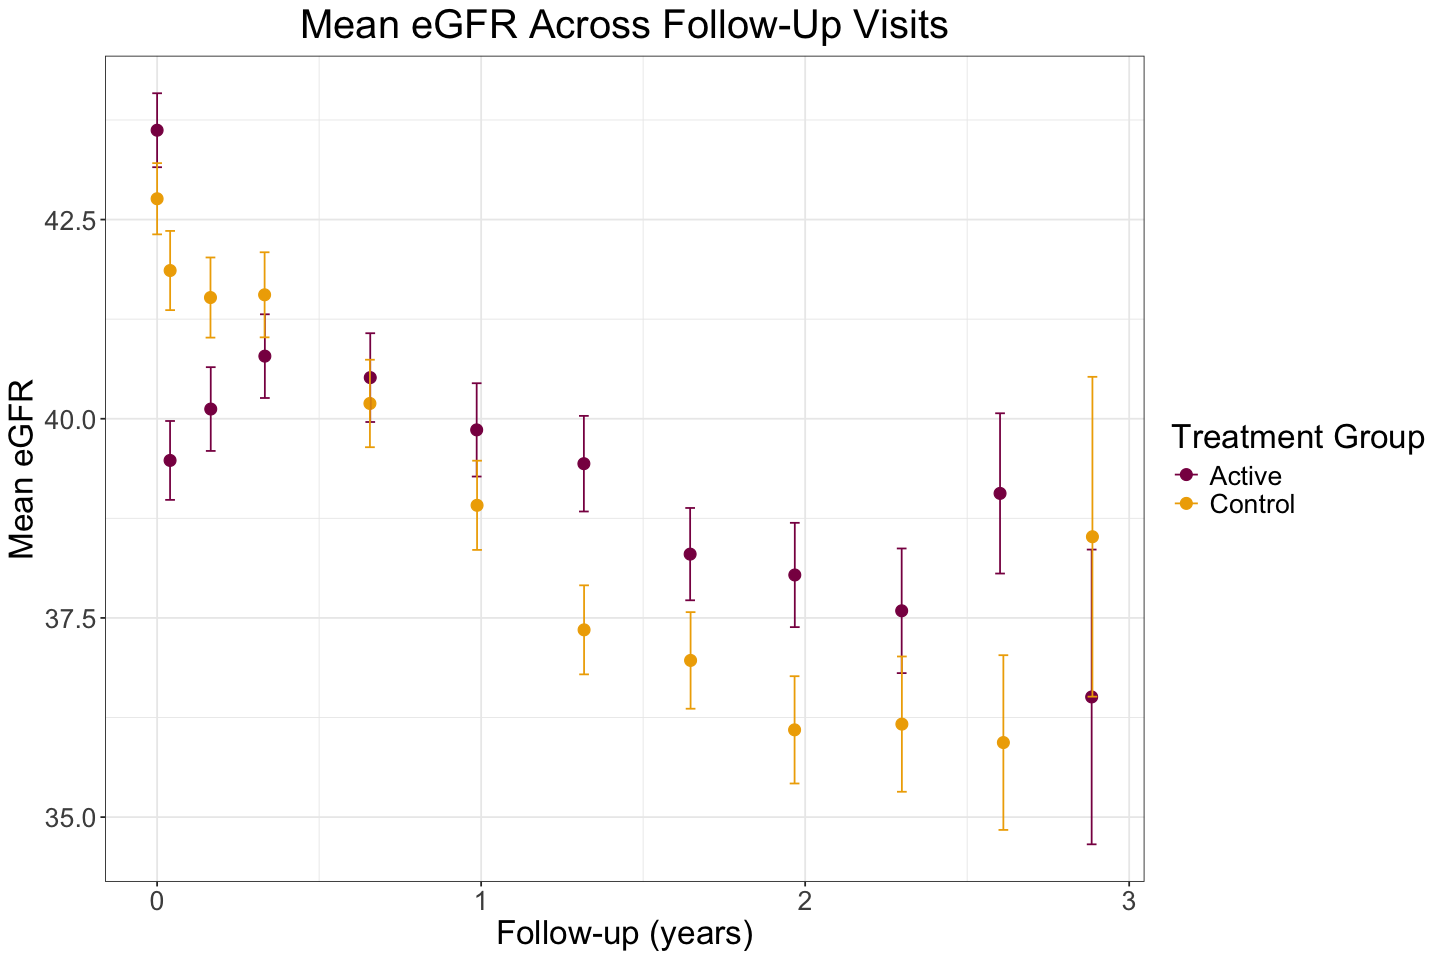

In [21]:
# ggplot mean AVAL by TRT_GRP and visit number
options(repr.plot.width = 12, repr.plot.height = 8) 
g <- ggplot(egfr_plot_df, aes(x=mean_yrs, y=mean_eGFR, color=TRT_GRP)) + 
    geom_point(size=3) + 
    geom_errorbar(aes(ymin=sterr_min, ymax=sterr_max), width=.03) +
    labs(title = 'Mean eGFR Across Follow-Up Visits', x = 'Visit number', y = 'Mean eGFR') + 
    theme_bw() + 
    theme(plot.title = element_text(hjust = 0.5))

# make the text larger
g <- g + theme(text = element_text(size=20, color = "black"))

# use astrazeneca colors for added style
g <- g + scale_color_manual(values = c('#8A0051', '#EFAB00'))

# change legent title
g <- g + labs(color = 'Treatment Group')

# Set x axis title
g <- g + xlab('Follow-up (years)')
# Add sample size counts to the bottom of the plot
#g <- g + geom_text(data=egfr_plot_df, aes(x=mean_yrs, y=0, label=n), size=5)
g

## Figure 2: Kaplan-Meier curve of time to death endpoint

In [22]:
# For this plot, we can just use the previously created "cox_df" dataframe
# the relevant columns are "Death (adj)" and "DAY_Death (adj)"
# For patients that did not die, the "DAY_Death (adj)" column is equal to the max follow-up day
head(cox_df)
dim(cox_df)

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days,MAX_FOLLOW_UP
,<int>,<int>,<int>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721,0,0,0,0,0,0,721,721,721,721,721,721,721
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696,0,0,0,0,0,0,696,696,696,696,696,696,696
3,3,1,28,4,Active,<30 ml/min/1.73 m2,954,0,0,0,0,0,0,954,954,954,954,954,954,954
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,884,0,0,0,0,0,0,884,884,884,884,884,884,884
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008,0,0,0,0,0,0,1008,1008,1008,1008,1008,1008,1008
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923,0,0,0,0,0,0,923,923,923,923,923,923,923


[1] 1500   20

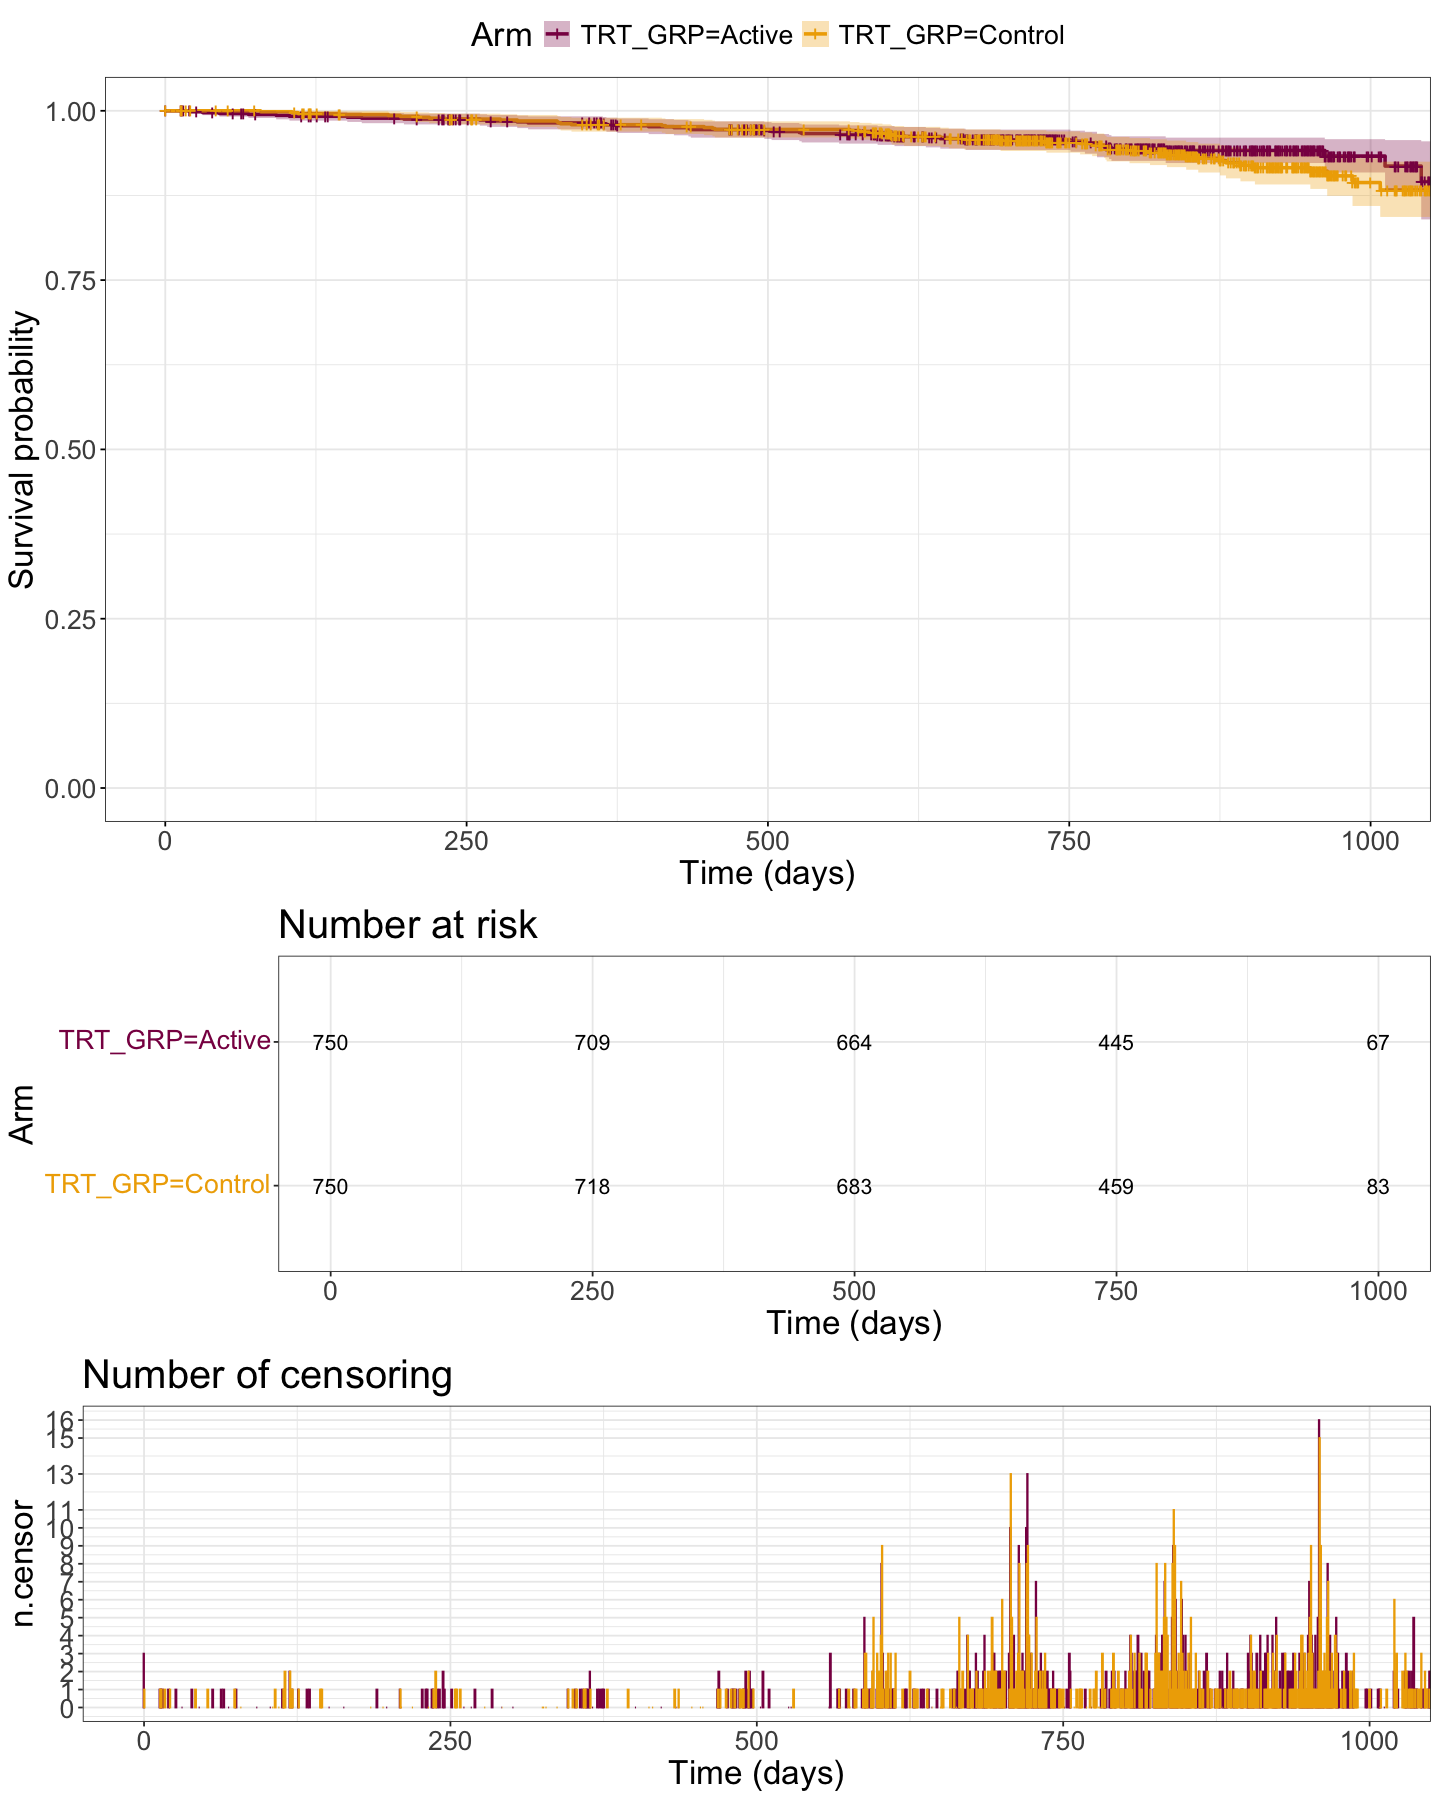

In [23]:
options(repr.plot.width = 12, repr.plot.height = 15) 

# 0/1 indicator for death
event_col = 'Death (adj)'
# Days to event  or days to max follow-up
event_time_col = 'DAY_Death (adj)'

# re-fit the cox ph model
cox_model <- coxph(Surv(get(event_time_col), get(event_col)) ~ TRT_GRP + strata(STRATAN) + EGFRBL, data=cox_df)

# Fit the Kaplan-Meier Survival Curve split by treatment group
km_fit_group <- survfit(Surv(get(event_time_col), get(event_col)) ~ TRT_GRP , data = cox_df)

# make the plot with added censoring and patient at-risk tables/plots
ggsurvplot(km_fit_group, 
           conf.int = TRUE, 
           pval = FALSE, 
           risk.table = TRUE, 
           legend.title = "Arm",
           palette = c("#8A0051", "#EFAB00"),
           xlab = "Time (days)",
           ncensor.plot = TRUE,
           ggtheme = theme_bw()+theme(text = element_text(size=20, color = "black")))
           

In [24]:
# The KM curves are flatter than what we are used to seeing
# but not that many patient actually died in this dataset
# The plot is still informative, but the y-axis is not as dramatic as we might be used to seeing
table(ADET$PARAM)


  Chronic dialysis (adj) >=90 days                        Death (adj) 
                                49                                 90 
   Sustained >=40% decline in eGFR    Sustained >=50% decline in eGFR 
                               203                                117 
   Sustained >=57% decline in eGFR Sustained eGFR<15 (mL/min/1.73 m2) 
                                66                                 79 